# Channel Crowding

### Importing libraries 

In [122]:
%matplotlib inline

In [261]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from pymongo import MongoClient

import datetime

import re
import random
from pprint import pprint

import operator

### Connecting to MongoDB

In [124]:
client = MongoClient('inspiring_boyd', 27017)
db = client.wifi
client_collection = db.client_data
ap_collection = db.ap_data

### Queries

I find unique channels and add to the set

In [125]:
ap_cursor = ap_collection.find()

#unique channels
channel = set()
for j, doc in enumerate(ap_cursor):
    channel.add(doc['channel'])


For each channel, I look up AP MACs and then find clients that associated with the MAC addresses. 

In [126]:
#<channel : number of stations> 
station_dict = dict()

# <channel: number of access points>
ap_dict = dict()

#<channel: number of stations per access point>
rate_dict = dict()

for ch in channel:
    ap_mac = set() # a set of access point MAC address
    
    ap = ap_collection.find({"channel": ch} ) # only find documents with given channel
    
    #get bssid and store in a set
    for row in ap:
        ap_mac.add(row['bssid']) 
    
    ap_dict[ch] = len(ap_mac)
    
    number_of_stations = 0
    for mac in ap_mac:
        client_cursor = client_collection.find({"bssid":mac})
        number_of_stations += client_cursor.count()
    station_dict[ch] = number_of_stations
    
    rate_dict[ch] = station_dict.get(ch) / ap_dict.get(ch) 

print "Done!"


Done!


### Graphs

update title, x label, and y label sizes

In [402]:
# update title, x label, and y label sizes
def update_size( title_size, x_size, y_size): 
    plt.rc('axes',titlesize = title_size)
    plt.rc('xtick',labelsize = x_size)
    plt.rc('ytick',labelsize = y_size)
    


The keys in **station_dict()** map are channels and the values are the numbers of stations.

I use **station_dict()** map to plot *Number of Clients vs Channel* graph

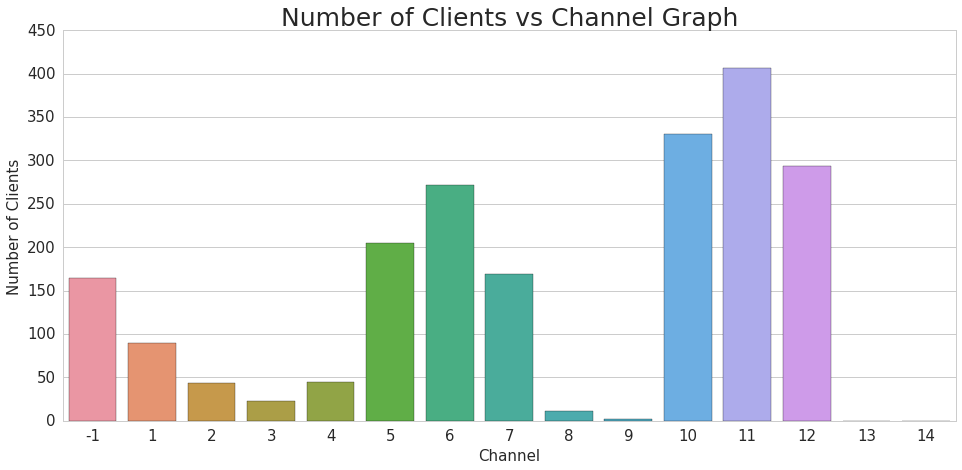

In [505]:
# Number of Stations vs Channel graph

update_size(25, 15, 15)

fig = plt.figure(figsize=(16,7))
ax = fig.add_subplot(111)


sns.set_style("whitegrid")
ax = sns.barplot(x=station_dict.keys(), y = station_dict.values())
ax.set_title('Number of Clients vs Channel Graph')
ax.set_xlabel('Channel', fontsize = 15)
ax.set_ylabel('Number of Clients', fontsize = 15)

plt.show()

The keys in **ap_dict()** map are channels and the values are the numbers of APs.

I use **station_dict()** to plot *Number of Access Point vs Channel* graph.

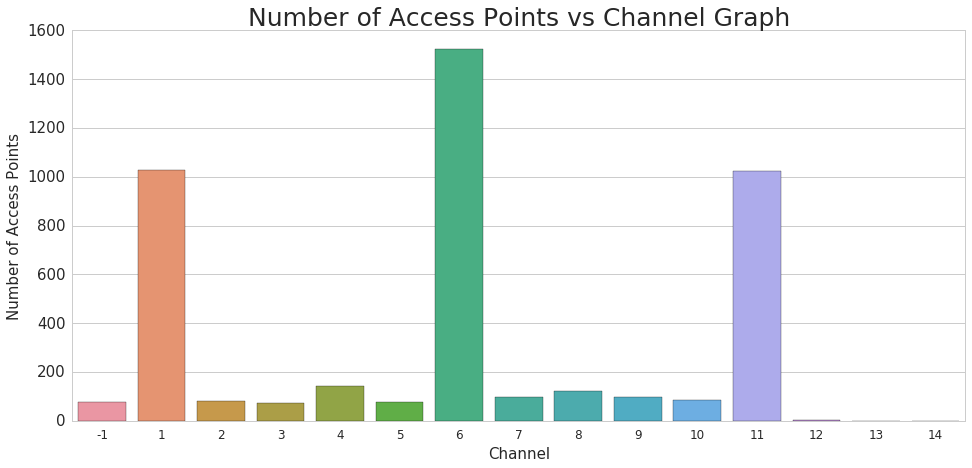

In [442]:
# Number of Access Point vs Channel graph

#update_size(25, 15, 15)

fig = plt.figure(figsize=(16,7))
ax = fig.add_subplot(111)



ax = sns.barplot(x=ap_dict.keys(), y = ap_dict.values())
ax.set_title('Number of Access Points vs Channel Graph')
ax.set_xlabel('Channel', fontsize = 15)
ax.set_ylabel('Number of Access Points', fontsize = 15)
plt.show()

The keys in **rate_dict()** map are channels and the values are the numbers of clients per AP.

I use **rate_dict()** to plot *Number of Clients per Access Point vs channel graph* graph.

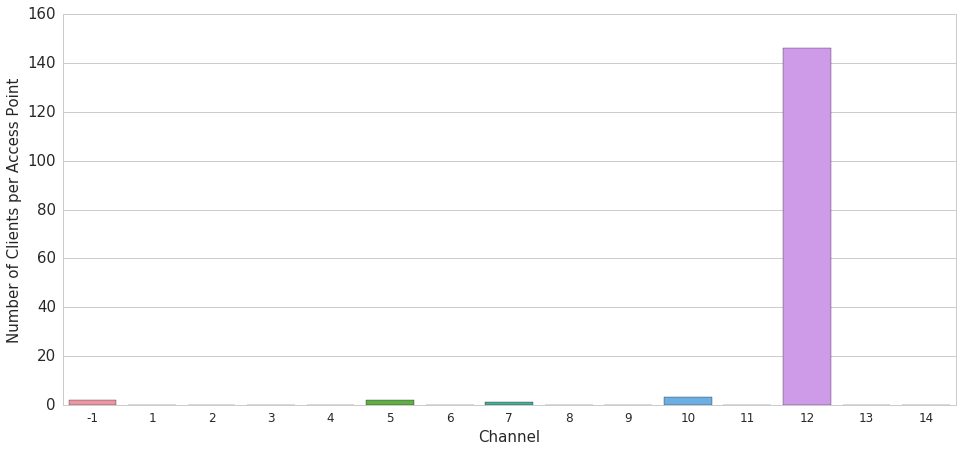

In [441]:
# Number of Clients per Access Point vs channel graph

#update_size(25, 15, 15)

fig = plt.figure(figsize=(16,7))
ax = fig.add_subplot(111)

ax = sns.barplot(x=rate_dict.keys(), y = rate_dict.values())
ax.set_xlabel('Channel', fontsize = 15)
ax.set_ylabel('Number of Clients per Access Point', fontsize = 15)


plt.show()

In [493]:
from netaddr import *

# number of "Others" devices
other = 0

def make_mfg_count(client_cursor):

    mac_set = set()
    manuf_list = []

    #get unique MACs
    for doc in client_cursor:
        mac_set.add(doc['mac'])


    total_device = 0 # count total devices
    manuf_dict = dict() # key is brand name, value is number of devices of that brand name


    for doc in mac_set:
        try:
            total_device+=1
            mac = EUI(doc)
            brand = mac.oui.registration().org[0:30]
            if ( manuf_dict.has_key(brand)):
                manuf_dict[brand] = manuf_dict.get(brand) + 1

            else:
                manuf_dict[brand] = 1

        except:
            pass


    manuf_graph = dict()

    i = 0
    sum_max = 0
    while i<10:

        temp = max(manuf_dict.iteritems(), key=operator.itemgetter(1))

        sum_max += temp[1]
        manuf_graph[temp[0]] = temp[1]
        del manuf_dict[temp[0]]
        i+=1
    global other
    other = total_device - sum_max
    #manuf_graph['Others'] = total_device - sum_max
    
    return manuf_graph

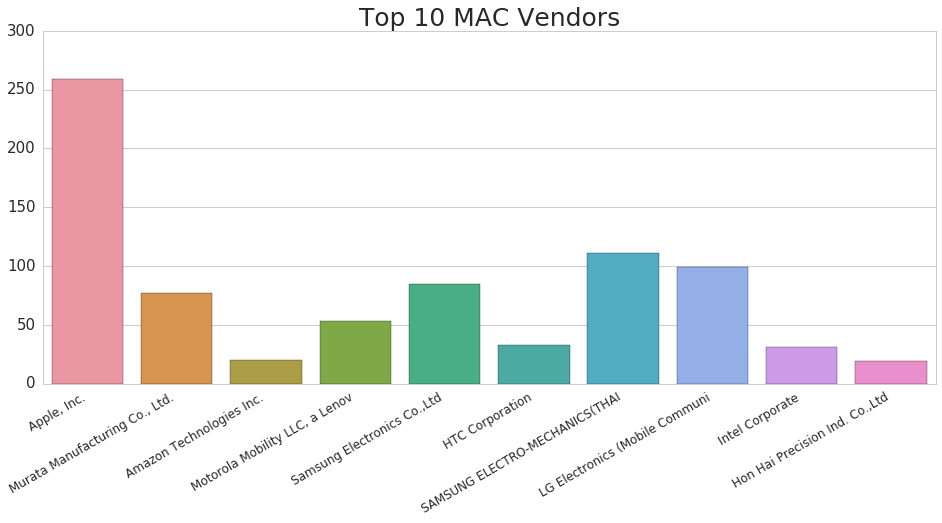

In [494]:
client_cursor = client_collection.find()

manuf_graph = make_mfg_count(client_cursor)

fig = plt.figure(figsize=(16,7))
ax = fig.add_subplot(111)
ax.set_title('Top 10 MAC Vendors')

ax = sns.barplot( x = manuf_graph.keys(), y = manuf_graph.values())

fig.autofmt_xdate()

plt.show()

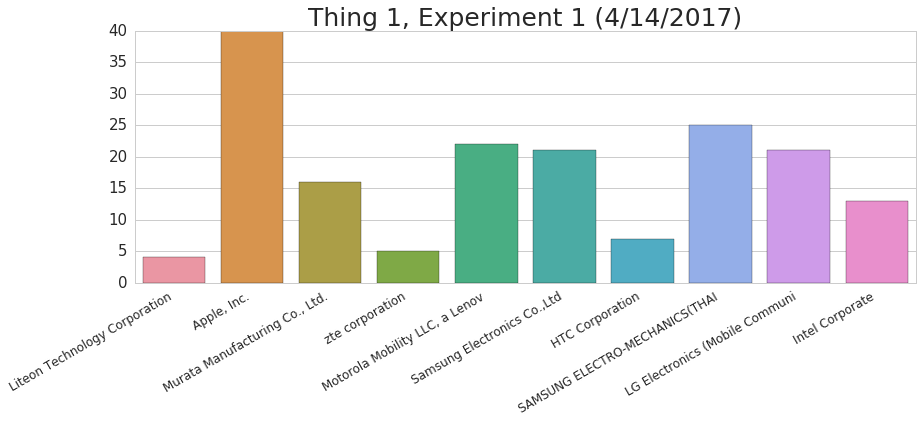

In [502]:
host = "thing1"

client_cursor = client_collection.find({'host': host, 
                                        'time': {"$gt":datetime.datetime(2017,4,13), 
                                                 "$lt": datetime.datetime(2017,4,14)} })

manuf_graph = make_mfg_count(client_cursor)

fig = plt.figure(figsize=(14,5))
ax = fig.add_subplot(111)

ax = sns.barplot( x = manuf_graph.keys(), y = manuf_graph.values())

ax.set_title("Thing 1, Experiment 1 (4/14/2017)")

fig.autofmt_xdate()

plt.show()

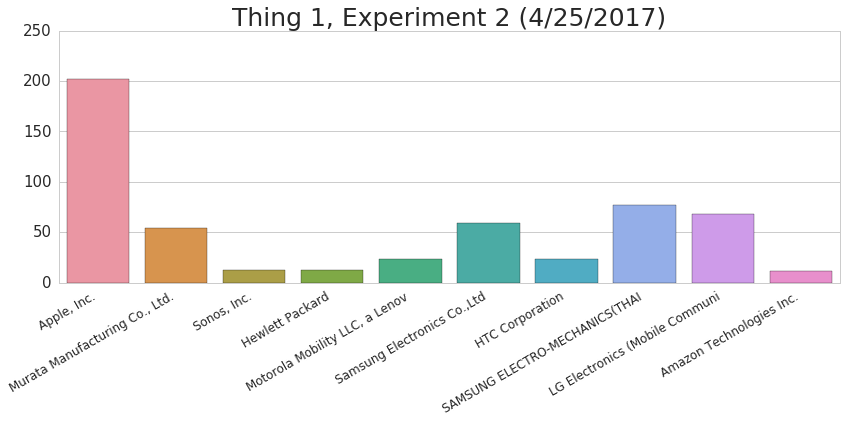

In [503]:
host = "thing1"

client_cursor = client_collection.find({'host': host, 'time': {"$gt":datetime.datetime(2017,4,24), "$lt": datetime.datetime(2017,4,25)} })

manuf_graph = make_mfg_count(client_cursor)

fig = plt.figure(figsize=(14,5))
ax = fig.add_subplot(111)

ax = sns.barplot( x = manuf_graph.keys(), y = manuf_graph.values())

ax.set_title("Thing 1, Experiment 2 (4/25/2017)")

fig.autofmt_xdate()

plt.show()

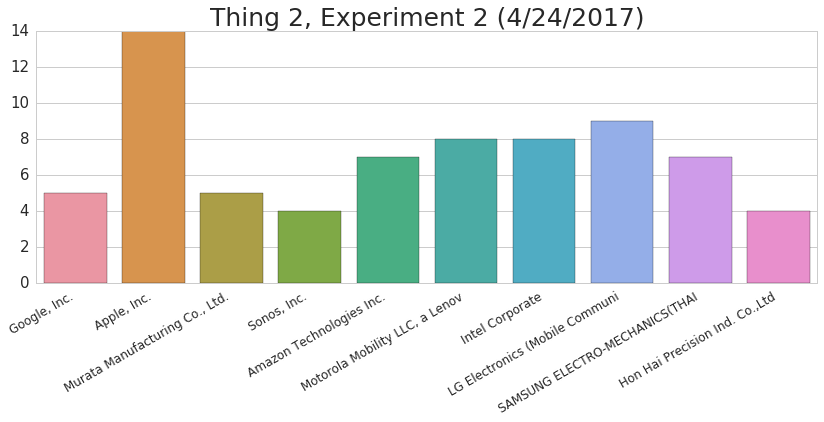

In [504]:
host = "thing2"

client_cursor = client_collection.find({'host': host, 
                                        'time': {"$gt":datetime.datetime(2017,4,23), 
                                                 "$lt": datetime.datetime(2017,4,25)} })

manuf_graph = make_mfg_count(client_cursor)

fig = plt.figure(figsize=(14,5))
ax = fig.add_subplot(111)

ax = sns.barplot( x = manuf_graph.keys(), y = manuf_graph.values())

ax.set_title("Thing 2, Experiment 2 (4/24/2017)")

fig.autofmt_xdate()

plt.show()

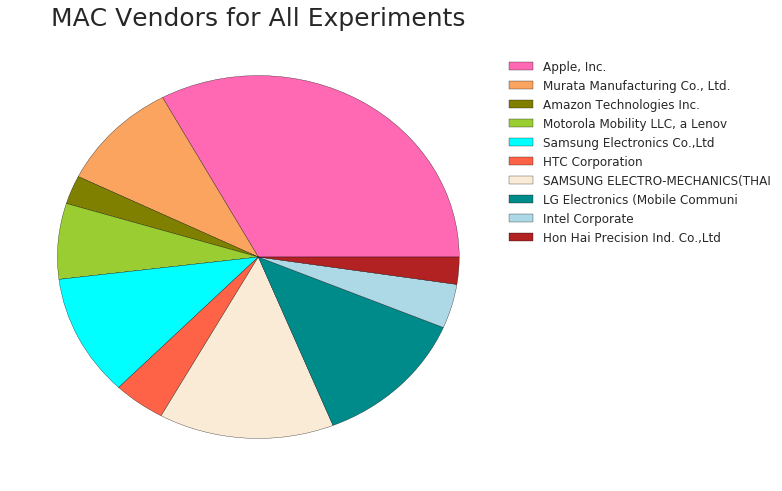

In [501]:

client_cursor = client_collection.find()

manuf_graph = make_mfg_count(client_cursor)

#manuf_graph['Others'] = other

fig = plt.figure(figsize=(9,9))
ax = fig.add_subplot(111)

plt.rc('legend', fontsize = 12)

colors = ['hotpink', 'sandybrown', 'olive',
          'yellowgreen','aqua','tomato',
          'antiquewhite','darkcyan','lightblue',
         'firebrick','blue']

ax = plt.pie( manuf_graph.values(),  colors = colors)
plt.title('MAC Vendors for All Experiments')
plt.legend(labels = manuf_graph.keys(), bbox_to_anchor=(1.32, 0.87),
           bbox_transform=plt.gcf().transFigure)


fig.autofmt_xdate()
plt.show()